# Travelling Salesman Problem

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/evolution/tsp.ipynb)

In this tutorial, we will use PyGlove to find a solution to the [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP). The TSP tries to answer: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?" It is an NP-hard problem in combinatorial optimization, important in theoretical computer science and operations research.

*(Disclaimer: PyGlove is designed to be used with problems with evaluation time greater than sub-second, since the TSP can be evaluated in nano/micro-seconds, you may find slowdown in PyGlove's solution. Bear in mind that the overhead from PyGlove for each iteration is in sub-seconds)*

In [1]:
!pip install pyglove

## Defining City and Route

First we define classes to represent a `City` with a 2D location on the map, and a `Route` that traversing the cities in order.

In [2]:
import math

class City:
  """Represents a city with location (x, y) on the map."""

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def distance(self, other):
    return math.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)

class Route:
  """Represents a route that traverse the cities in their appearing order."""

  def __init__(self, cities):
    self.cities = cities

  def length(self):
    l = 0
    for i in range(0, len(self.cities)):
      current = i
      next = (i + 1) % len(self.cities)
      l += self.cities[current].distance(self.cities[next])
    return l


Then we generate 25 cities with randomly chosen locations on the map, with x=[0, 99) and y=[0, 100). This can be easily done via `pg.random_sample`.

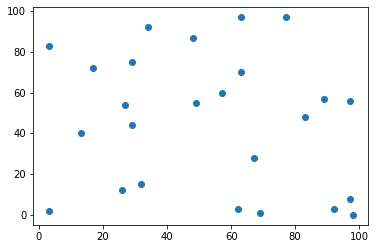

In [3]:
import pyglove as pg

# Symbolizing City and Route so that their objects
# can be symbolically manipulated.
City = pg.symbolize(City)
Route = pg.symbolize(Route)

# Generating 25 cities.
cities = list(pg.random_sample(
    City(x=pg.oneof(range(100)), y=pg.oneof(range(100))), 25, seed=1))

# Plot the cities.
import matplotlib.pyplot as plt
plt.plot([c.x for c in cities], [c.y for c in cities], 'o')
plt.show()

We also introduce a method to plot a route so it's easier for the reader to make sense of a route.

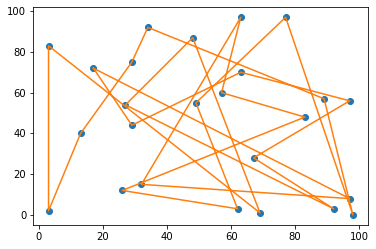

In [4]:
import numpy as np
def plot_route(route):
  data = np.array([[c.x, c.y] for c in route.cities + [route.cities[0]]])
  plt.plot([c.x for c in cities], [c.y for c in cities], 'o')
  plt.plot(data[:, 0], data[:, 1])
  plt.show()

plot_route(Route(cities))

## Solving TSP using PyGlove

TSP can be tackled as a search problem, while the search space is all possible routes, the search algorithm tries to minimize the length computed from the route. Here we use `pg.sample` to express such a search process.

In [5]:
def tsp(algo, num_trials):
  history = []
  best_route, min_len = None, None
  # The route space is a Route object
  # with all possible permutations generated
  # from given cities.
  route_space = Route(pg.permutate(cities))

  # `pg.sample` is the way to sample an example
  # route from the route space. Each iteration
  # will emit a `feedback` object, which can be
  # used to pass the reward to the controller.
  for route, feedback in pg.sample(
      route_space,
      algo,
      num_examples=num_trials):
    l = route.length()
    history.append(l)
    if min_len is None or min_len > l:
      best_route, min_len = route, l
    # We negate the route length as the reward since
    # the algorithm is to maximize the reward value.
    feedback(-l)

  # Plot the search curve and the best route.
  plt.plot(list(range(num_trials)), history)
  plt.show()
  print(f'Route length: {min_len}')
  plot_route(best_route)

Let's start with a random search.

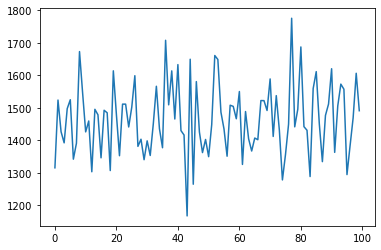

Route length: 1167.4112697950238


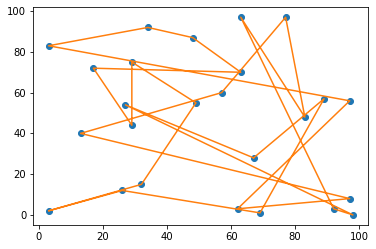

In [6]:
# Doing TSP using random search.
tsp(pg.geno.Random(seed=1), 100)

Next, let's use PyGlove's evolution framework to create different search algorithms to solve this problem.

In [7]:
def evolution(op, population_size=50, tournament_size=20, seed=1):
  return pg.evolution.Evolution(
      (pg.evolution.selectors.Random(tournament_size, seed=seed)
       >> pg.evolution.selectors.Top(2) 
       >> op),
      population_init=(pg.geno.Random(seed=seed), population_size),
      population_update=pg.evolution.selectors.Last(population_size))

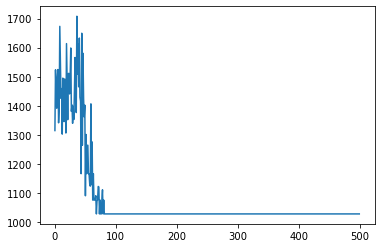

Route length: 1029.3224071662476


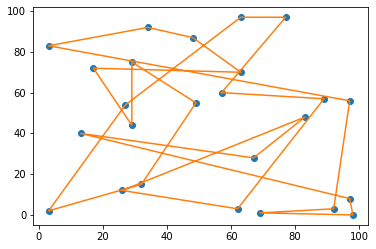

In [8]:
# Partially mapped crossover (PMX).
tsp(evolution(pg.evolution.recombinators.PartiallyMapped(seed=1)), 500)

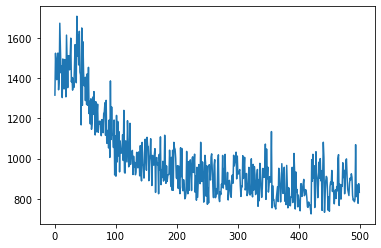

Route length: 724.7975187775785


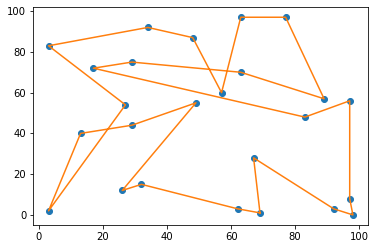

In [9]:
# Swap mutation.
tsp(evolution(pg.evolution.mutators.Swap(seed=1)), 500)

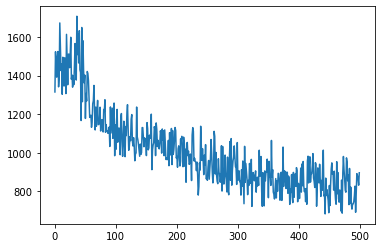

Route length: 683.5030846609448


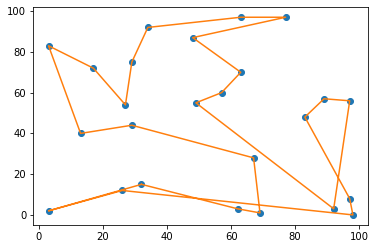

In [10]:
# Pipeline operators: PMX crossover + Swap mutation.
tsp(evolution(
    (pg.evolution.recombinators.PartiallyMapped(seed=1)
     >> pg.evolution.mutators.Swap(seed=1))), 500)

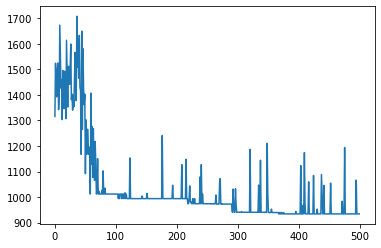

Route length: 934.1022916000118


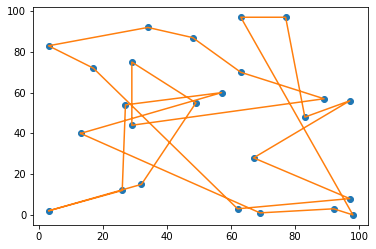

In [11]:
# Order crossover + Swap mutation with a small mutation probability
tsp(evolution(pg.evolution.recombinators.PartiallyMapped(seed=1)
              >> pg.evolution.mutators.Swap(seed=1).with_prob(0.1)), 500)

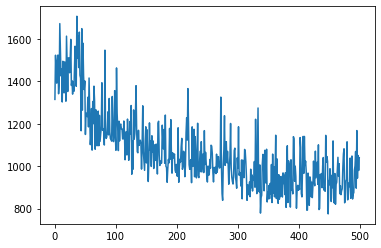

Route length: 775.1478343571931


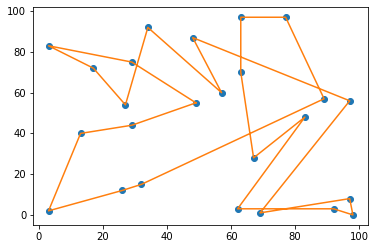

In [12]:
# Use a combination of different crossovers.
tsp(evolution(
    pg.evolution.Choice([
        (pg.evolution.recombinators.PartiallyMapped(seed=1), 1/3),
        (pg.evolution.recombinators.Order(seed=1), 1/2),
        (pg.evolution.recombinators.Cycle(seed=1), 1.0),
    ], limit=1) >> pg.evolution.mutators.Swap(seed=1)), 500)